# **DATA OVERVIEW**

In [ ]:
import pandas as pd

df = pd.read_csv('/content/sarkas-tiktok raw.csv')
df.head()

,annotation_id,annotator,created_at,id,komentar,label,lead_time,sentiment,updated_at
0,168,1,2025-05-15T14:25:04.665298Z,2001,“So here fasion a look” 😭🙏🏻😭,NaN,8.207,tidak sarkastik,2025-05-15T14:25:22.928570Z
1,169,1,2025-05-15T14:25:07.616260Z,2002,michele Halim low budget 😢,NaN,2.691,sarkastik,2025-05-15T14:25:07.616260Z
2,170,1,2025-05-15T14:25:16.596475Z,2003,"""So here fashionel look""",NaN,8.736,tidak sarkastik,2025-05-15T14:25:16.596475Z
3,214,1,2025-05-15T14:46:26.445668Z,2004,awww,NaN,61.037,tidak sarkastik,2025-05-15T14:46:26.445668Z
4,215,1,2025-05-15T14:47:17.636211Z,2005,finnal look bkn fashion look hohhh😭🤣,NaN,50.946,tidak sarkastik,2025-05-15T14:47:17.636211Z


In [ ]:
df = df[['komentar', 'sentiment']]
df.head()

,komentar,sentiment
0,“So here fasion a look” 😭🙏🏻😭,tidak sarkastik
1,michele Halim low budget 😢,sarkastik
2,"""So here fashionel look""",tidak sarkastik
3,awww,tidak sarkastik
4,finnal look bkn fashion look hohhh😭🤣,tidak sarkastik


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   komentar   1000 non-null   object
 1   sentiment  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [ ]:
df.describe()

,komentar,sentiment
count,1000,1000
unique,994,2
top,🥰🥰🥰,tidak sarkastik
freq,3,618


In [ ]:
print("Null di tiap kolom:\n", df.isna().sum())

Null di tiap kolom:
 komentar     0
sentiment    0
dtype: int64


In [ ]:
# prompt: hitung berapa komentar sarkas dan tida

sarkas_count = df[df['sentiment'] == 'sarkastik'].shape[0]
tidak_sarkas_count = df[df['sentiment'] == 'tidak sarkastik'].shape[0]

print(f"Jumlah komentar sarkas: {sarkas_count}")
print(f"Jumlah komentar tidak sarkas: {tidak_sarkas_count}")

Jumlah komentar sarkas: 382
Jumlah komentar tidak sarkas: 618


In [ ]:
df = df.dropna(subset=['sentiment']).copy()
df.head(10)

,komentar,sentiment
0,“So here fasion a look” 😭🙏🏻😭,tidak sarkastik
1,michele Halim low budget 😢,sarkastik
2,"""So here fashionel look""",tidak sarkastik
3,awww,tidak sarkastik
4,finnal look bkn fashion look hohhh😭🤣,tidak sarkastik
5,bjir michelle halim,sarkastik
6,cosplay michelle halim kah? tapi kenapa gini w...,sarkastik
7,dihina tak tumbang dipuji tak pantas😇,sarkastik
8,gw kiraa diaa lagi megang bukett 😭😭,tidak sarkastik
9,STRES SMUA STRESS😭👊🏻,tidak sarkastik


# **PRE-PROCESSING**

In [ ]:
!pip install -q emoji nltk pandas openpyxl  # openpyxl utk baca .xlsx slang

import re, string, emoji, pandas as pd
from nltk.corpus import stopwords
from nltk import download
download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Kamus slang
slang_df = pd.read_excel('/content/normalisasi.xlsx')
SLANG = dict(zip(slang_df.iloc[:,0], slang_df.iloc[:,1]))

# Stopword tambahan
with open('/content/stopwordTambahan.txt', 'r') as f:
    tambahan = f.read().split()

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('indonesian'))
STOPWORDS.update(tambahan)

In [ ]:
# emoji_map = {
#     ":upside_down_face:": "<sarcasm_face>",
#     ":face_with_tears_of_joy:": "<laugh>",
#     ":rolling_on_the_floor_laughing:": "<laugh>",
#     ":unamused_face:": "<eyeroll>",
#     ":smirking_face:": "<smirk>",
#     ":face_with_raised_eyebrow:": "<skeptical>",
#     ":face_with_symbols_on_mouth:": "<censor>",
#     ":expressionless_face:": "<blank>",
#     ":face_with_monocle:": "<pretend_smart>",
#     ":winking_face:": "<wink>",
# }

In [ ]:
# def replace_emojis(text):
#     text = emoji.demojize(text, delimiters=(" ", " "))  # 🙃 → :upside_down_face:
#     for e, token in emoji_map.items():
#         text = text.replace(e, token)
    # return text

def normalize_slang(tokens):
    return [SLANG.get(t, t) for t in tokens]

def clean_comment(text):
    text = str(text).lower()
    # text = replace_emojis(text)

    # Hapus URL, mention, hashtag
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", " ", text)

    # Pangkas huruf ganda lebih dari 2x → maksimal 2
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Buang tanda baca, kecuali yang ekspresif (! ? < >)
    allowed = set("!?<>")
    text = ''.join(ch if ch in allowed or ch not in string.punctuation else ' ' for ch in text)

    # Spasi rapi
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenisasi
    tokens = text.split()

    # Slang → baku
    tokens = normalize_slang(tokens)

    # Stopword & karakter tunggal
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]

    return ' '.join(tokens)

In [ ]:
df['clean'] = df['komentar'].apply(clean_comment)
df[['komentar', 'clean']].sample(10, random_state=42)

,komentar,clean
521,bljar uu gih...gmana prosesnya...,bljar uu gih prosesnya
737,emg ada yg iri?,emang iri?
740,aduhhh cape gw😏,aduhh capai gw😏
660,tahu ..kan aman mtor di luarr untung nya ituu ...,aman mtor luarr untung rb bolleh sih
411,lu doang,doang
678,@match@ 😭,
626,otw pindah negara🗿,otw pindah negara🗿
513,semua juga lebih parah terlibat...😂😂😂,parah terlibat 😂😂
859,😅😅😅😅 simpel aja sih\r\nelo mau beli iPhone yg ...,😅😅 simpel sih beli iphone kemarin dolar kebeli...
136,astaga ngakak liat sendal nya😭🙏,astaga ngakak liat sendal nya😭🙏


In [ ]:
df.head()

,komentar,sentiment,clean
0,“So here fasion a look” 😭🙏🏻😭,tidak sarkastik,“so here fasion ah look” 😭🙏🏻😭
1,michele Halim low budget 😢,sarkastik,michele halim lemah budget
2,"""So here fashionel look""",tidak sarkastik,so here fashionel look
3,awww,tidak sarkastik,aww
4,finnal look bkn fashion look hohhh😭🤣,tidak sarkastik,finnal look fashion look hohh😭🤣


# **Tokenizing**

In [ ]:
def tokenize_text(text):
  tokenized_text = text.split()
  return tokenized_text

# Apply the tokenize_text function to the 'clean' column of the df DataFrame
df['tokens'] = df['clean'].apply(lambda x: tokenize_text(x))

# Display the head of the DataFrame to see the new 'tokens' column
df.head()

,komentar,sentiment,clean,tokens
0,“So here fasion a look” 😭🙏🏻😭,tidak sarkastik,“so here fasion ah look” 😭🙏🏻😭,"[“so, here, fasion, ah, look”, 😭🙏🏻😭]"
1,michele Halim low budget 😢,sarkastik,michele halim lemah budget,"[michele, halim, lemah, budget]"
2,"""So here fashionel look""",tidak sarkastik,so here fashionel look,"[so, here, fashionel, look]"
3,awww,tidak sarkastik,aww,[aww]
4,finnal look bkn fashion look hohhh😭🤣,tidak sarkastik,finnal look fashion look hohh😭🤣,"[finnal, look, fashion, look, hohh😭🤣]"


In [ ]:
# Ensure Sastrawi is installed
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Create the stemmer factory and stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Define the lemmatization function
def lemmatize_text(tokens):
  lemmatized_tokens = [stemmer.stem(token) for token in tokens]
  return lemmatized_tokens

# Apply the lemmatize_text function to the 'tokens' column to create the 'lemmas' column
df['lemmas'] = df['tokens'].apply(lemmatize_text)

# Display the head of the DataFrame to see the new 'lemmas' column and confirm its creation
df.head()

# Now, access the 'lemmas' column and the 'sentiment' column
sentences = df.lemmas.values
labels = df.sentiment.values

# **EDA**

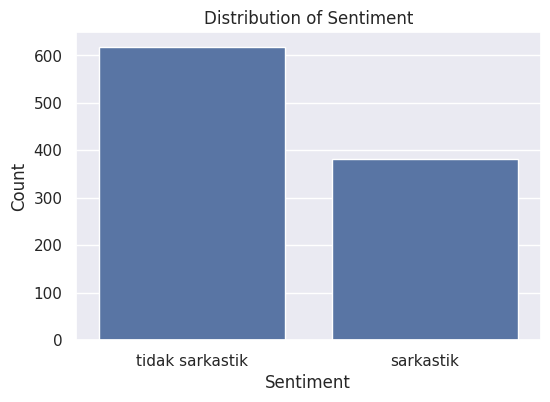

In [ ]:
# prompt: buatkan eda mengenai persebaran data

import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of sentiment
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()



<ipython-input-62-89040cc503da>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


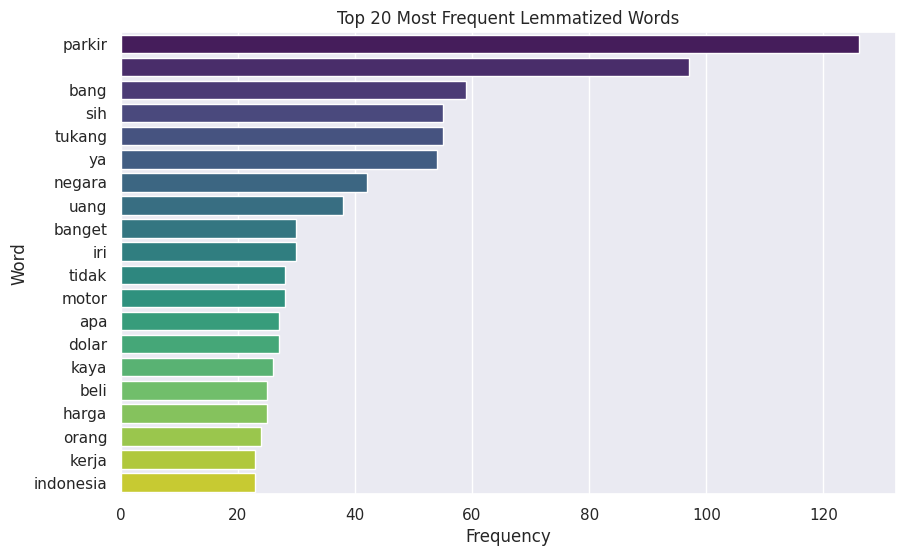

In [ ]:
# prompt: buatkan 1 eda mengenai kata paling sering muncul

import matplotlib.pyplot as plt
from collections import Counter

# Gabungkan semua lemma dari semua komentar
all_lemmas = [lemma for sublist in df['lemmas'] for lemma in sublist]

# Hitung frekuensi kemunculan setiap lemma
lemma_counts = Counter(all_lemmas)

# Ambil 20 kata yang paling sering muncul
most_common_lemmas = lemma_counts.most_common(20)

# Pisahkan kata dan jumlah kemunculan
words, counts = zip(*most_common_lemmas)

# Buat bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), palette='viridis')
plt.title('Top 20 Most Frequent Lemmatized Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

<ipython-input-64-fa3277f760f5>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(emojis), palette='viridis')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128511 (\N{MOYAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129392 (\N{SMILING FACE WITH SMILING EYES AND THREE HEARTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1

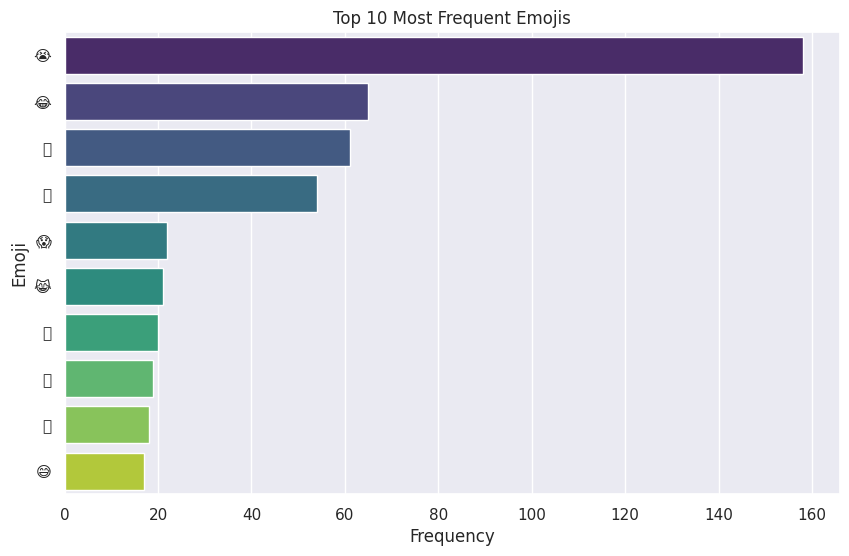

In [ ]:
# prompt: buatkan 1 eda mengenai emot sering muncul

import matplotlib.pyplot as plt
import emoji

def extract_emojis(text):
  """Extracts all emojis from a string."""
  return [c for c in text if emoji.is_emoji(c)]

# Terapkan fungsi extract_emojis ke kolom 'komentar' (sebelum pre-processing)
df['emojis'] = df['komentar'].apply(extract_emojis)

# Gabungkan semua emoji dari semua komentar
all_emojis = [e for sublist in df['emojis'] for e in sublist]

# Hitung frekuensi kemunculan setiap emoji
emoji_counts = Counter(all_emojis)

# Ambil 10 emoji yang paling sering muncul (atau sesuaikan jumlahnya)
most_common_emojis = emoji_counts.most_common(10)

# Pisahkan emoji dan jumlah kemunculan
emojis, counts = zip(*most_common_emojis)

# Buat bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(emojis), palette='viridis')
plt.title('Top 10 Most Frequent Emojis')
plt.xlabel('Frequency')
plt.ylabel('Emoji')
plt.show()

# **Splitting**

In [ ]:
!pip install transformers

In [ ]:
!git clone https://huggingface.co/arthd24/indobert_sarcasm

fatal: destination path 'indobert_sarcasm' already exists and is not an empty directory.


In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="w11wo/indobert-base-p1-twitter-indonesia-sarcastic")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("w11wo/indobert-base-p1-twitter-indonesia-sarcastic")
model = AutoModelForSequenceClassification.from_pretrained("w11wo/indobert-base-p1-twitter-indonesia-sarcastic")

In [ ]:
sentences = df.lemmas.values
# Access the 'sentiment' column instead of the non-existent 'label' column
labels = df.sentiment.values

In [ ]:
print("Original: ", sentences[51])

# Join the list of lemmas into a single string
sentence_string = ' '.join(sentences[51])

print("Tokenized: ", tokenizer.tokenize(sentence_string))

print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence_string)))

Original:  ['']
Tokenized:  []
Token IDS:  []


In [ ]:
print("Original: ", sentences[69])

# Join the list of lemmas into a single string before tokenization
sentence_string_69 = ' '.join(sentences[69])

print("Tokenized: ", tokenizer.tokenize(sentence_string_69))

print("Token IDS: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence_string_69)))

Original:  ['rela', '10', 'ribu', 'anak', 'anak', 'jual', 'keliling', 'dari', 'pada', 'ribu', 'tukang', 'parkir', 'wkwkwk']
Tokenized:  ['rela', '10', 'ribu', 'anak', 'anak', 'jual', 'keliling', 'dari', 'pada', 'ribu', 'tukang', 'parkir', 'wkwkwk']
Token IDS:  [7479, 740, 2276, 436, 436, 1403, 9115, 98, 126, 2276, 5850, 5222, 19720]


In [ ]:
input_ids = []

for sent in sentences:
    # Join the list of lemmas into a single string
    sentence_string = ' '.join(sent)

    # Tokenisasi kalimat tanpa menambahkan token [CLS] dan [SEP]
    # Pass the joined string to the tokenizer
    tokens = tokenizer.tokenize(sentence_string)

    # Menambahkan token [CLS] di awal dan [SEP] di akhir
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    # Mengonversi token menjadi ID menggunakan tokenizer
    encoded_sent = tokenizer.convert_tokens_to_ids(tokens)

    input_ids.append(encoded_sent)

# Menampilkan hasil untuk salah satu kalimat
print("Original: ", sentences[51])
# Note: The tokenizer.tokenize method expects a string, so we join the list here for printing as well
print("Tokenized: ", tokenizer.tokenize(' '.join(sentences[51])))
print("Token IDs: ", input_ids[51])

Original:  ['']
Tokenized:  []
Token IDs:  [2, 3]


In [ ]:
print("Max sentence length: ", max([len(sen) for sen in input_ids]))

Max sentence length:  62


In [ ]:
from keras.preprocessing.sequence import pad_sequences

MAX_LEN =65

print("Padding/trucating all sentence to %d values" % MAX_LEN)
print('Padding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print("Done")

Padding/trucating all sentence to 65 values
Padding token: "[PAD]", ID: 0
Done


In [ ]:
attention_mask = []

for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent] # - Jika ID token adalah 0, maka itu adalah padding, set mask ke 0.
                                                      # - Jika ID token > 0, maka itu adalah token asli, set mask ke 1.

  attention_mask.append(att_mask)

In [ ]:
from sklearn.model_selection import train_test_split

# Use 70% for training and 30% for validation.
train_input, test_input, train_labels, test_labels = train_test_split(input_ids,
                                                                      labels,
                                                                      random_state=2020,  # mengatur seed agar pembagian dataset dapat direproduksi
                                                                      test_size=0.3)
# Do the same for the masks.
train_mask, test_mask, _, _ = train_test_split(attention_mask,
                                               labels,
                                               random_state=2020,
                                               test_size=0.3)

In [ ]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  (700, 65)
Label:  (700,)
Mask:  (700, 65)

== Test ==
Input:  (300, 65)
Label:  (300,)
Mask:  (300, 65)


In [ ]:
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Inisialisasi LabelEncoder
label_encoder = LabelEncoder()

# Fit dan transform label sentimen menjadi nilai numerik
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels) # Gunakan transform saja pada test set

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

# Konversi NumPy arrays ke PyTorch tensors
train_input = torch.tensor(train_input)
train_labels = torch.tensor(train_labels_encoded) # Gunakan label yang sudah di-encode
train_mask = torch.tensor(np.array(train_mask)) # Konversi list ke numpy array sebelum ke tensor

test_input = torch.tensor(test_input)
test_labels = torch.tensor(test_labels_encoded) # Gunakan label yang sudah di-encode
test_mask = torch.tensor(np.array(test_mask))   # Konversi list ke numpy array sebelum ke tensor

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
# Membuat DataLoader dalam PyTorch

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our testing set.
test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# **Modeling**

In [ ]:
# from transformers.optimization import AdamW # Hapus atau komentari baris ini

from transformers import BertForSequenceClassification, BertConfig, get_linear_schedule_with_warmup
from torch.optim import AdamW # Import AdamW dari torch.optim

# model = BertForSequenceClassification.from_pretrained(
#     "indolem/indobert-base-uncased",
#     num_labels = 3,
#     output_attentions = False,
#     output_hidden_states = False
# )

# Check if a GPU is available and move the model to the appropriate device
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('there are %d GPU(s) available.' % torch.cuda.device_count())
  print('we will use the GPU: ', torch.cuda.get_device_name(0))
  model.to(device) # Use .to(device) to move the model
else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")
  model.to(device) # Use .to(device) to move the model

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
params = list(model.named_parameters())

print("The BERT model has {:} different named parameters.".format(len(params)))

print("==== Embedding Layer ====")
for p in params[0:5]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== First Transformers ====")
for p in params[5:21]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

print("==== Output Layer ====")
for p in params[-4:]:
  print("{:<60} {:>12}".format(p[0], str(tuple(p[1].size()))))

total_params = sum(p.numel() for p in model.parameters())
print("==== Total Parameters ====")
print(f'Total Parameters: {total_params}')

The BERT model has 201 different named parameters.
==== Embedding Layer ====
bert.embeddings.word_embeddings.weight                       (31923, 768)
bert.embeddings.position_embeddings.weight                     (512, 768)
bert.embeddings.token_type_embeddings.weight                     (2, 768)
bert.embeddings.LayerNorm.weight                                   (768,)
bert.embeddings.LayerNorm.bias                                     (768,)
==== First Transformers ====
bert.encoder.layer.0.attention.self.query.weight               (768, 768)
bert.encoder.layer.0.attention.self.query.bias                     (768,)
bert.encoder.layer.0.attention.self.key.weight                 (768, 768)
bert.encoder.layer.0.attention.self.key.bias                       (768,)
bert.encoder.layer.0.attention.self.value.weight               (768, 768)
bert.encoder.layer.0.attention.self.value.bias                     (768,)
bert.encoder.layer.0.attention.output.dense.weight             (768, 768)
bert.e

In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                             num_warmup_steps = 0,
                                             num_training_steps = total_steps)

# **BERT**

In [ ]:
import numpy as np

# Menghitung akurasi prediksi model terhadap label pada suatu tugas klasifikasi.
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

# Mengelola waktu yang diukur dalam detik dan mengembalikan waktu yang diformat dengan representasi jam:menit:detik
def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import time
import datetime
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, accuracy_score
import seaborn as sb
import matplotlib.pyplot as plt

# --------------
# PERSIAPAN AWAL
# --------------

# Setting Seed:
# mengatur seed agar hasil eksperimen dapat diproduksi
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Inisialisasi Variabel:
# menyimpan nilai loss selama pelatihan.
loss_values = []


# --------------
# PELATIHAN MODEL
# --------------

# Loop Epoch:
# dilakukan loop sebanyak epochs (jumlah epoch yang ditentukan).
for epoch_i in range(0, epochs):

  # ===================================
  #              Training
  # ===================================

  print("======= Epoch {:} / {:} =======".format(epoch_i+1, epochs))
  print("Training...")

  t0 = time.time() # measure how long the training epoch takes.

  # Inisialisasi Total Loss:
  # deklasrasi nilai loss = 0 (direset ke 0 di awal setiap epoch).
  total_loss = 0

  # Set Model ke Mode Training:
  # mengaktifkan mode training pada model.
  model.train()

  # Loop Batches:
  # for each batch of training data (dilakukan loop untuk setiap batch di dalam train_dataloader).
  for step, batch in enumerate(train_dataloader):

    # Progress update/progress report every 1 batches:
    # diberikan informasi mengenai progress setiap batch.
    if step % 1 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)

      print("Batch {:>5,} of {:>5,}.     Elapsed: {:}".format(step, len(train_dataloader), elapsed))

    # Muat Data ke GPU/CPU:
    # token ids/data masukan, attention masks, dan label dari batch dimuat ke perangkat GPU.
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad() # PyTorch
                      # dlm setiap batch, set gradien mjd set zero

    # Forward Pass:
    # model dimasukkan token ids, attention mask, dan label. Output berupa nilai loss.
    outputs = model(b_input_ids,
                    token_type_ids=None,  # diperlukan jika ingin melakukan klasifikasi menggunakan 2 sentences yg dianggap 1 data.
                    attention_mask=b_input_mask,
                    labels=b_labels)

    loss = outputs[0] # ambil nilai loss, utk mengambil nilai sebenarnya: menggunakan loss.item kemuddian lakukan backward.

    # Backward Pass:
    # gradien dihitung dan dilakukan backward pass.
    total_loss += loss.item()

    loss.backward()

    # PyTorch
    # Menerapkan normalisasi gradien untuk mencegah eksplosi gradien.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Optimasi dan Scheduler:
    # optimizer melakukan langkah optimisasi (mengupdate parameter model) dan scheduler dipindahkan.
    optimizer.step()

    scheduler.step()

  # Hitung Rata-rata Loss (total loss/jmh batch):
  # rata-rata loss dihitung untuk satu epoch.
  avg_train_loss = total_loss / len(train_dataloader)

  # Simpan Loss:
  # rata-rata loss disimpan di dalam loss_values.
  loss_values.append(avg_train_loss)

  print("   Average training loss: {0:.2f}".format(avg_train_loss))
  print("   Training epoch took: {:}".format(format_time(time.time() - t0)))

print("Training complete!")

# --------------
# PENGUJIAN MODEL
# --------------

print("\nRunning Testing...")

t0 = time.time()

# Set Model ke Mode Evaluasi:
# model.eval() mengubah model ke mode evaluasi.
model.eval()

# Lists to store true and predicted labels
flat_true_labels = []
flat_prediction = []

test_accuracy = 0
nb_test_steps = 0

# Loop Batches pada Data Uji:
# dilakukan loop untuk setiap batch di dalam test_dataloader.
for batch in test_dataloader:

  # Data disimpan dalam GPU
  # data uji dimuat ke perangkat GPU.
  batch = tuple(t.to(device) for t in batch)

  # Pisahkan batch lagi
  b_input_ids, b_input_mask, b_labels = batch

  # Forward Pass pada Data Uji:
  # dengan torch.no_grad(), model melakukan prediksi pada data uji.
  with torch.no_grad():
    outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask)

  # Mengambil nilai output
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  flat_prediction.extend(np.argmax(logits, axis=1).flatten())
  flat_true_labels.extend(label_ids.flatten())


  # Hitung Akurasi pada Data Uji (jmh data yg sesuai/seluruh data):
  # akurasi dihitung dengan fungsi flat_accuracy().
  tmp_test_accuracy = flat_accuracy(logits, label_ids)

  test_accuracy += tmp_test_accuracy

  nb_test_steps += 1

# Tampilkan Hasil Pengujian:
# tampilkan akurasi dan waktu pengujian.
print("   Accuracy: {0:.2f}".format(test_accuracy/nb_test_steps))
print("   Testing took: {:}".format(format_time(time.time() - t0)))

======= Epoch 1 / 10 =======
Training...
Batch     1 of    44.     Elapsed: 0:00:00
Batch     2 of    44.     Elapsed: 0:00:00
Batch     3 of    44.     Elapsed: 0:00:01
Batch     4 of    44.     Elapsed: 0:00:01
Batch     5 of    44.     Elapsed: 0:00:01
Batch     6 of    44.     Elapsed: 0:00:01
Batch     7 of    44.     Elapsed: 0:00:01
Batch     8 of    44.     Elapsed: 0:00:02
Batch     9 of    44.     Elapsed: 0:00:02
Batch    10 of    44.     Elapsed: 0:00:02
Batch    11 of    44.     Elapsed: 0:00:02
Batch    12 of    44.     Elapsed: 0:00:02
Batch    13 of    44.     Elapsed: 0:00:02
Batch    14 of    44.     Elapsed: 0:00:03
Batch    15 of    44.     Elapsed: 0:00:03
Batch    16 of    44.     Elapsed: 0:00:03
Batch    17 of    44.     Elapsed: 0:00:03
Batch    18 of    44.     Elapsed: 0:00:03
Batch    19 of    44.     Elapsed: 0:00:04
Batch    20 of    44.     Elapsed: 0:00:04
Batch    21 of    44.     Elapsed: 0:00:04
Batch    22 of    44.     Elapsed: 0:00:04
Batch    23 o

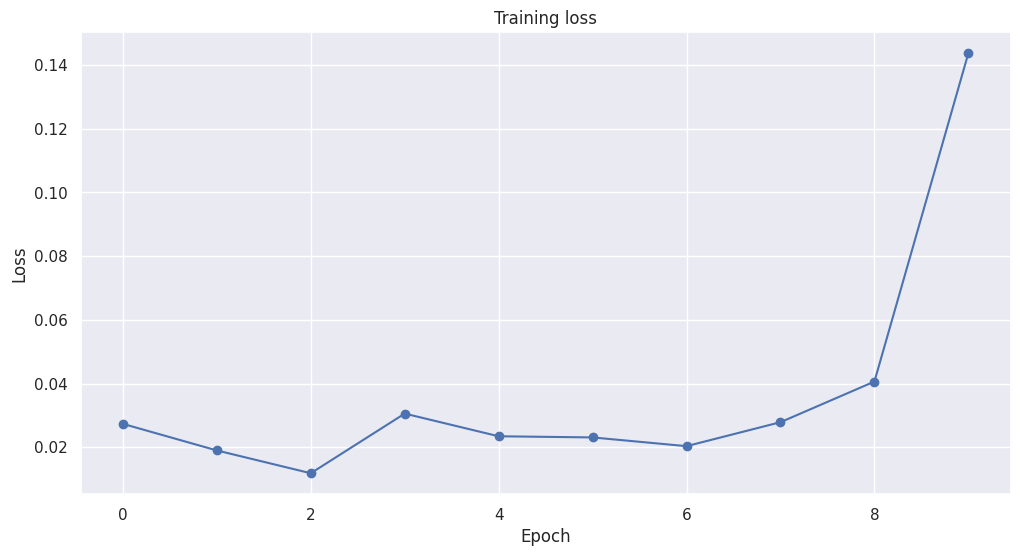

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (12, 6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

print(classification_report(flat_true_labels, flat_prediction))

              precision    recall  f1-score   support

           0       0.53      0.58      0.55       113
           1       0.73      0.70      0.71       187

    accuracy                           0.65       300
   macro avg       0.63      0.64      0.63       300
weighted avg       0.66      0.65      0.65       300



In [ ]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(flat_true_labels, flat_prediction)

print("MCC: %.3f" %mcc)

MCC: 0.267


In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(flat_true_labels, flat_prediction)

print("ACC: %.3f" %acc)

ACC: 0.650
